<a href="https://colab.research.google.com/github/yagniksram007/Neural_Networks_Lab/blob/main/NN_Lab_Programs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Program 4

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.7262 - loss: 0.7895 - val_accuracy: 0.8502 - val_loss: 0.4213
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 113ms/step - accuracy: 0.8686 - loss: 0.3675 - val_accuracy: 0.8765 - val_loss: 0.3451
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.8863 - loss: 0.3111 - val_accuracy: 0.8832 - val_loss: 0.3190
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.9013 - loss: 0.2667 - val_accuracy: 0.8927 - val_loss: 0.2975
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 104ms/step - accuracy: 0.9087 - loss: 0.2458 - val_accuracy: 0.8992 - val_loss: 0.2874
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.9168 - loss: 0.2277 - val_accuracy: 0.9016 - val_loss: 0.2675
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 116ms/step - accuracy: 0.9230 - loss: 0.2127 - val_accuracy: 0.9046 - val_loss: 0.2604
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9282 - loss: 0

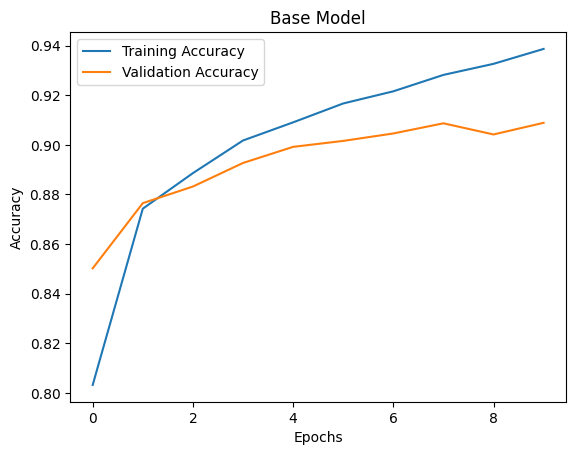

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 115ms/step - accuracy: 0.6343 - loss: 2.9181 - val_accuracy: 0.7820 - val_loss: 0.9414
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.7922 - loss: 0.8789 - val_accuracy: 0.7950 - val_loss: 0.7758
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.8126 - loss: 0.7411 - val_accuracy: 0.8178 - val_loss: 0.7181
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.8239 - loss: 0.6951 - val_accuracy: 0.8294 - val_loss: 0.6802
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 116ms/step - accuracy: 0.8280 - loss: 0.6727 - val_accuracy: 0.8258 - val_loss: 0.6696
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.8337 - loss: 0.6474 - val_accuracy: 0.8368 - val_loss: 0.6334
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.8431 - loss: 0.6230 - val_accuracy: 0.8321 - val_loss: 0.6339
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 110ms/step - accuracy: 0.8409 - loss: 0

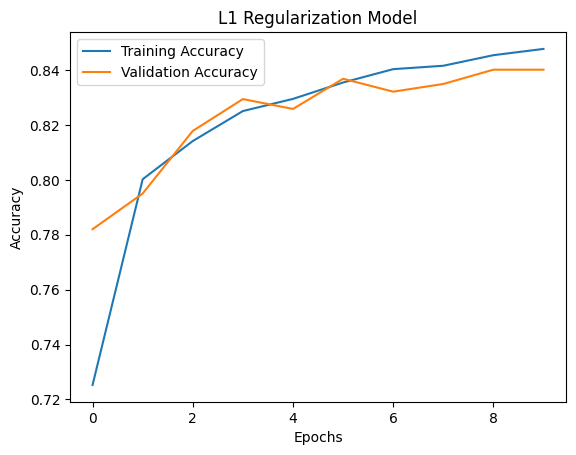

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.7140 - loss: 1.0061 - val_accuracy: 0.8431 - val_loss: 0.5719
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.8555 - loss: 0.5262 - val_accuracy: 0.8653 - val_loss: 0.4859
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.8719 - loss: 0.4616 - val_accuracy: 0.8666 - val_loss: 0.4680
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.8783 - loss: 0.4274 - val_accuracy: 0.8797 - val_loss: 0.4246
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.8887 - loss: 0.4002 - val_accuracy: 0.8842 - val_loss: 0.4141
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.8925 - loss: 0.3885 - val_accuracy: 0.8877 - val_loss: 0.3992
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.8914 - loss: 0.3845 - val_accuracy: 0.8783 - val_loss: 0.4195
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 117ms/step - accuracy: 0.8973 - loss: 0

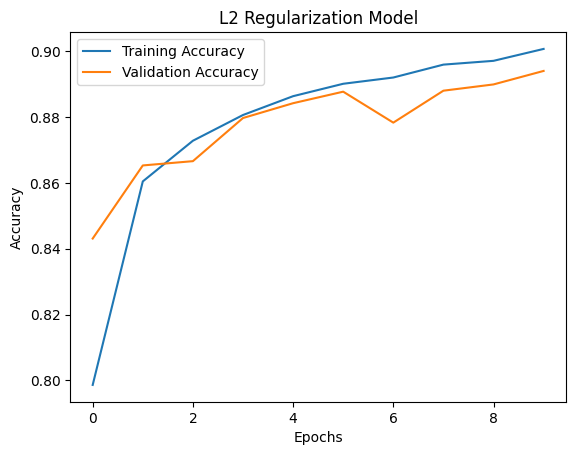

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.6565 - loss: 0.9437 - val_accuracy: 0.8354 - val_loss: 0.4492
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 118ms/step - accuracy: 0.8341 - loss: 0.4648 - val_accuracy: 0.8649 - val_loss: 0.3691
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8592 - loss: 0.3954 - val_accuracy: 0.8756 - val_loss: 0.3380
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.8742 - loss: 0.3519 - val_accuracy: 0.8831 - val_loss: 0.3168
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.8828 - loss: 0.3218 - val_accuracy: 0.8893 - val_loss: 0.3083
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 116ms/step - accuracy: 0.8911 - loss: 0.3046 - val_accuracy: 0.8928 - val_loss: 0.2970
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 112ms/step - accuracy: 0.8943 - loss: 0.2944 - val_accuracy: 0.8983 - val_loss: 0.2815
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.9007 - loss: 0

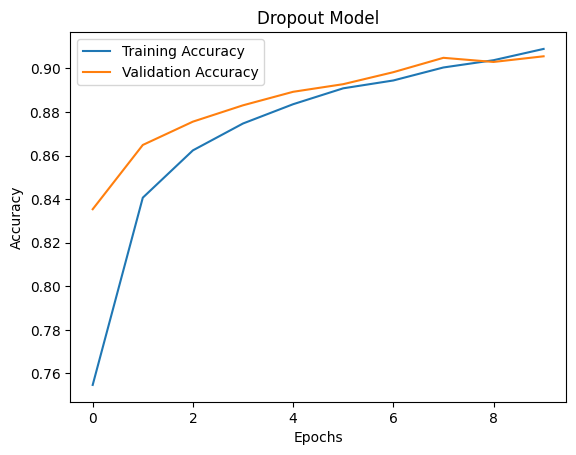

In [1]:
# Use the concept of regularization and dropout while designing the CNN model. Use the Fashion MNIST datasets. Record the Training accuracy and Test accuracy corresponding to the following architectures:
# a. Base Model
# b. Model with L1 Regularization
# c. Model with L2 Regularization
# d. Model with Dropout

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Step 1: Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Function to plot accuracy
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Step 2: Build and compile the models

# Base Model
def build_base_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model with L1 Regularization
def build_l1_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1),
                      kernel_regularizer=regularizers.l1(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                      kernel_regularizer=regularizers.l1(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model with L2 Regularization
def build_l2_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1),
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model with Dropout
def build_dropout_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to prevent overfitting
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 3: Train and Evaluate each Model
def train_and_evaluate(model, title):
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10, batch_size=128)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"{title} Test Accuracy: {test_acc * 100:.2f}%")
    plot_accuracy(history, title)

# Base Model
base_model = build_base_model()
train_and_evaluate(base_model, "Base Model")

# Model with L1 Regularization
l1_model = build_l1_model()
train_and_evaluate(l1_model, "L1 Regularization Model")

# Model with L2 Regularization
l2_model = build_l2_model()
train_and_evaluate(l2_model, "L2 Regularization Model")

# Model with Dropout
dropout_model = build_dropout_model()
train_and_evaluate(dropout_model, "Dropout Model")

